# Problem Set - Week 4
### Guillermo Trefogli

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.statespace import sarimax
from statsmodels.tools.eval_measures import aicc
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sktime.transformations.series import boxcox
from sktime.forecasting.arima import ARIMA

from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from scipy import stats
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## 1.  Exploratory Data Analysis

- There are 2 variables in the dataset: one measure for time (ds) and 1 float variable: CO2 level. when reading the data, I am setting ds as date by parsing. I am also indexing it already. CO2 is the variable of interest to make predictions.
- There are no missing values
- The ACF tests for CO2 is showing that autocorrelation is present.
- The time series plot for CO2 shows:
    - It is non-stationarity
    - Increasing trend over time
    - Seasonality is present in the trend over time

In [2]:
df = pd.read_csv('hw4_data.csv', parse_dates=['ds'])

In [3]:
df.head()

,ds,co2
0,1958-03-15,315.700
1,1958-04-15,317.450
2,1958-05-15,317.510
3,1958-06-15,316.685
4,1958-07-15,315.860


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      735 non-null    datetime64[ns]
 1   co2     735 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.6 KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
co2,735.0,354.210673,27.922811,313.2,328.785,351.34,376.515,414.83


In [6]:
df.isnull().sum()

ds     0
co2    0
dtype: int64

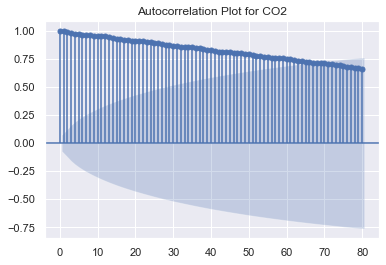

In [7]:
acf_plot_co2= plot_acf(df['co2'], lags=80, title='Autocorrelation Plot for CO2')

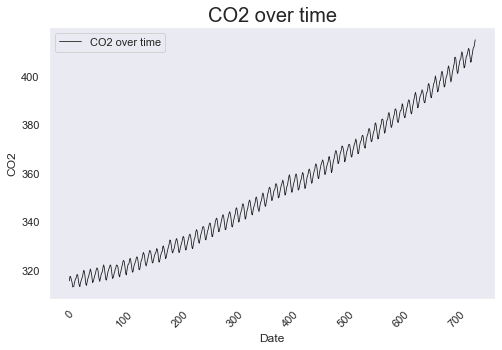

In [8]:
x = df['co2']

plt.figure(figsize=(8,5))  
plt.plot(x, color = 'k',label = "CO2 over time", ls = '-', lw = 0.8)

plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('CO2')
plt.title('CO2 over time', fontsize = 20)
plt.grid()
plt.legend()
plt.show()

## 2. Seasonal ARIMA

### A. Differencing data, ADF, and kpss

- **ADF test** is showing that **non-stationarity cannot be rejected**. The p-value in the test is greater than 0.05, which means that the null hypothesis of non-stationarity cannot be rejected.

- **KPSS test** is showing that **stationarity in the time series can be rejected**. The p-value is smaller than 0.05, which means that the null hypothesis of stationarity in the time series can be rejected.

- Based on the two test, we can consider that current time series is not stationary.

- We can differentiate the time series to solve for seasonality and non-seasonality. It is recommended to start with seasonality.

- See statistical and visual analysis below. 

#### Preparing data

In [9]:
y = df.groupby(pd.PeriodIndex(df['ds'], freq="M"))['co2'].mean()

In [10]:
from sktime.forecasting.all import temporal_train_test_split
y_train, y_test = temporal_train_test_split(y)

#### Testing stationarity

In [11]:
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from copy import deepcopy

alpha = 0.05

def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
def kpss_test(timeseries, trend='c'):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression=trend)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)    

#### Statistically

In [12]:
adf_test(y_train)

Results of Dickey-Fuller Test:
Test Statistic                   2.899722
p-value                          1.000000
#Lags Used                      13.000000
Number of Observations Used    537.000000
Critical Value (1%)             -3.442586
Critical Value (5%)             -2.866937
Critical Value (10%)            -2.569645
dtype: float64


In [13]:
kpss_test(y_train)

Results of KPSS Test:
Test Statistic            2.842068
p-value                   0.010000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


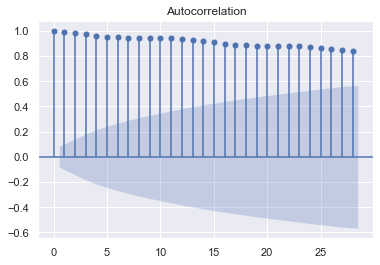

In [14]:
plot_acf(y_train)
plt.show()

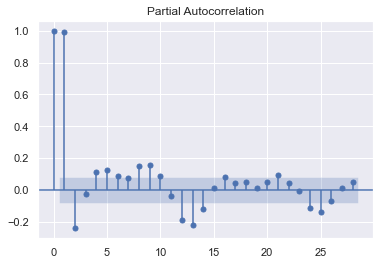

In [15]:
plot_pacf(y_train)
plt.show()

#### Diferentiating for seasonality

In [16]:
y_train_seas = y_train.diff(12).dropna()

### B. Non-seasonality, ACF, PACF 

- After differencing to solve for seasonality, we can test for stationarity again.

- **ADF test** is showing that **non-stationarity can be rejected**. The p-value is smaller than 0.05, which means that the null hypothesis of non-stationarity can be rejected.

- **KPSS test** is showing that **stationarity in the time series can be rejected**. The p-value is smaller than 0.05, which means that the null hypothesis of stationarity in the time series can be rejected.

- Based on the two tests, we cannot consider that current time series is stationary.

- After exploring ACF and PACF test, I notice that differencing to solve for non-seasonality is needed.

- After differencing to solve for non-seasonality, we verify stationarity using tests again. This time:
    
    - **ADF test** is showing that **non-stationarity can be rejected**. The p-value is smaller than 0.05, which means that the null hypothesis of non-stationarity can be rejected.
    
    - **KPSS test** is showing that **stationarity in the time series cannot be rejected**. The p-value is greater than 0.05, which means that the null hypothesis of stationarity in the time series cannot be rejected.

- See statistical and visual analysis below. 

#### Testing stationarity in differentiated time series

In [17]:
adf_test(y_train_seas)

Results of Dickey-Fuller Test:
Test Statistic                  -3.992752
p-value                          0.001449
#Lags Used                      13.000000
Number of Observations Used    525.000000
Critical Value (1%)             -3.442867
Critical Value (5%)             -2.867061
Critical Value (10%)            -2.569710
dtype: float64


In [18]:
kpss_test(y_train_seas)

Results of KPSS Test:
Test Statistic            1.300268
p-value                   0.010000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [19]:
y_train_seas

ds
1959-03    0.950
1959-04    0.270
1959-05    0.780
1959-06    1.465
1959-07    0.680
           ...  
2003-09    2.280
2003-10    2.750
2003-11    2.270
2003-12    1.910
2004-01    2.110
Freq: M, Name: co2, Length: 539, dtype: float64

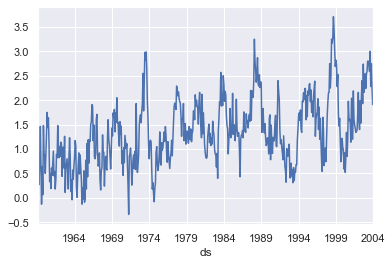

In [20]:
y_train_seas.plot()
plt.show()

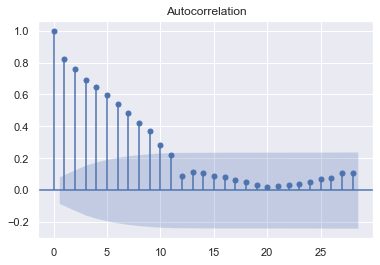

In [21]:
plot_acf(y_train_seas)
plt.show()

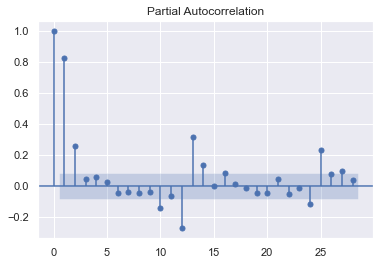

In [22]:
plot_pacf(y_train_seas)
plt.show()

#### Diferentiating for non-seasonality

In [23]:
y_train_non_seas = y_train_seas.diff(1).dropna()

In [24]:
adf_test(y_train_non_seas)

Results of Dickey-Fuller Test:
Test Statistic                -8.793377e+00
p-value                        2.209574e-14
#Lags Used                     1.400000e+01
Number of Observations Used    5.230000e+02
Critical Value (1%)           -3.442915e+00
Critical Value (5%)           -2.867082e+00
Critical Value (10%)          -2.569722e+00
dtype: float64


In [25]:
kpss_test(y_train_non_seas)

Results of KPSS Test:
Test Statistic            0.016553
p-value                   0.100000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


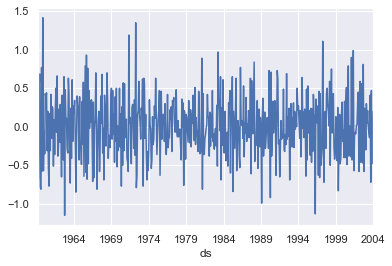

In [26]:
y_train_non_seas.plot()
plt.show()

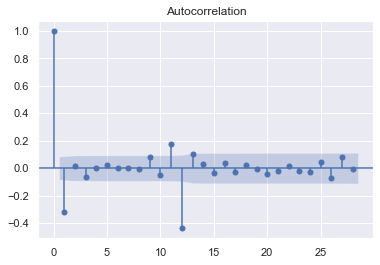

In [27]:
plot_acf(y_train_non_seas)
plt.show()

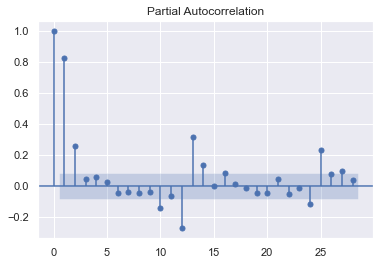

In [28]:
plot_pacf(y_train_seas)
plt.show()

### C. SARIMA

- Both AR L1 and MA L12 are showing significant but also not significant coefficients.
- Then, we can consider this is not a good model to make predictions.

In [29]:
sarima_model = sm.tsa.statespace.SARIMAX(endog=y_train,order=(9,1,3), seasonal_order=(10, 1, 10, 12))
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

                                                     SARIMAX Results                                                     
Dep. Variable:                                                               co2   No. Observations:                  551
Model:             SARIMAX(9, 1, 3)x(10, 1, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 12)   Log Likelihood                -103.419
Date:                                                           Fri, 29 Apr 2022   AIC                            272.838
Time:                                                                   19:02:10   BIC                            414.337
Sample:                                                               03-31-1958   HQIC                           328.187
                                                                    - 01-31-2004                                         
Covariance Type:                                                             opg                                         
                 coef   

### D. Residuals

- Residuals are normal distributed after dealing with the drop in the plot.
- Also Ljung-Box test is not significant.

<AxesSubplot:xlabel='ds'>

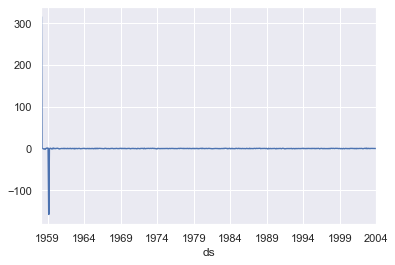

In [30]:
resid = sarima_fit.resid
resid.plot()

#### Exploring drop in the plot

In [31]:
resid=resid[12:]
resid

ds
1959-03   -157.680001
1959-04     -0.680015
1959-05      0.318871
1959-06      0.777787
1959-07     -0.594749
              ...    
2003-09      0.243635
2003-10      0.011347
2003-11     -0.110675
2003-12     -0.108053
2004-01      0.016439
Freq: M, Length: 539, dtype: float64

<AxesSubplot:xlabel='ds'>

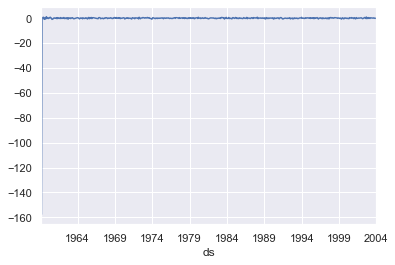

In [32]:
resid.plot()

#### Fixing the drop

<AxesSubplot:xlabel='ds'>

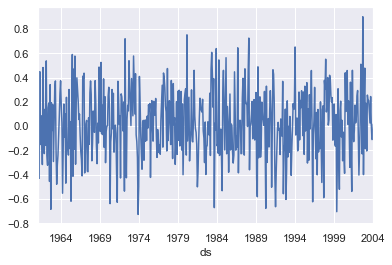

In [33]:
resid=resid[24:]
resid.plot()

<AxesSubplot:>

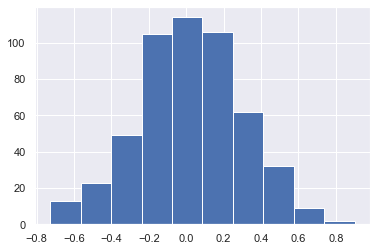

In [34]:
resid.hist()

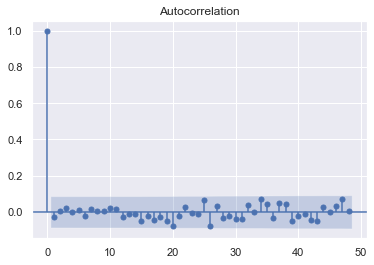

In [35]:
plot_acf(resid, lags=48)
plt.show()

In [36]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,1.457067,0.999063,1.438395,0.999115


### E. Predictions

In [37]:
y_pred=sarima_fit.forecast(steps = len(y_test))

<AxesSubplot:xlabel='ds'>

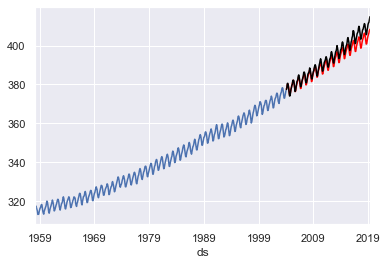

In [38]:
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

In [39]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
smape = MeanAbsolutePercentageError(symmetric=True)
smape(y_test, y_pred)

0.005345291642172526

In [40]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
mase = MeanAbsoluteScaledError()
mase(y_test, y_pred, y_train=y_train)

1.9798754319379046

In [41]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError
mae = MeanAbsoluteError()
mae(y_test, y_pred)

2.1311019172028356

In [42]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_test, y_pred)

7.369409513185

In [43]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
mape = MeanAbsolutePercentageError(symmetric=False)
mape(y_test, y_pred)

0.005322696666081465

## 3 Auto Arima

### A. Fitting the model

In [44]:
from sktime.forecasting.arima import AutoARIMA

In [51]:
autoarima_model = AutoARIMA(D=1, sp=12)
autoarima_model.fit(y_train)

In [46]:
fh = list(range(1, 1+len(y_test)))
y_pred = autoarima_model.predict(fh=fh )

<AxesSubplot:xlabel='ds'>

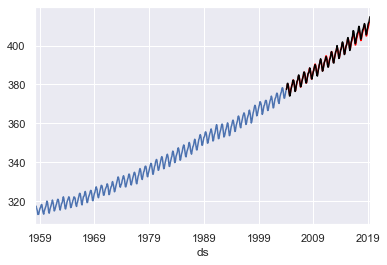

In [52]:
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

### B. Model summary

In [48]:
autoarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  551
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -111.667
Date:                            Fri, 29 Apr 2022   AIC                            233.335
Time:                                    19:02:36   BIC                            254.774
Sample:                                         0   HQIC                           241.721
                                            - 551                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0017      0.001      1.785      0.074      -0.000       0.004
ar.L1          0.2043      0.111      1.845      0.065      -0.013       0.421
ma.L1         -0.5415      0.099     -5.471      0.000      -0.736      -0.348
ma.S.L12      -0.8648      0.025    -34.893      0.000      -0.913      -0.816
sigma2         0.0860      0.005     16.185      0.000       0.076       0.096
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.25
Prob(Q):                              0.83   Prob(JB):                         0.88
Heteroskedasticity (H):               0.83   Skew:                            -0.05
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### C. Residuals

- Residuals are normal distributed, which was expected.

In [56]:
from pmdarima.arima import auto_arima

autoarima_model2 = auto_arima(y_train,
                      test='adf',
                      max_p=5, max_q=5,
                      D=1,
                      m=12,
                      seasonal=True,
                      max_P = 5, max_Q = 5,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
autoarima_model2.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1130.178, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=410.243, Time=0.94 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=827.929, Time=0.34 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1976.514, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=512.858, Time=0.19 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=368.939, Time=1.82 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=351.325, Time=6.03 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=340.132, Time=5.01 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=328.726, Time=10.42 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=293.631, Time=16.27 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=293.842, Time=9.31 sec
 ARIMA(1,0,0)(5,1,2)[12] intercept   : AIC=297.148, Time=18.28 sec
 ARIMA(1,0,0)(4,1,2)[12] intercept   : AIC=297.241, Time=10.13 sec
 ARIMA(0,0,0)(5,1,1)[12] interc

ARIMA(order=(4, 0, 0), scoring_args={}, seasonal_order=(5, 1, 1, 12),
      suppress_warnings=True)

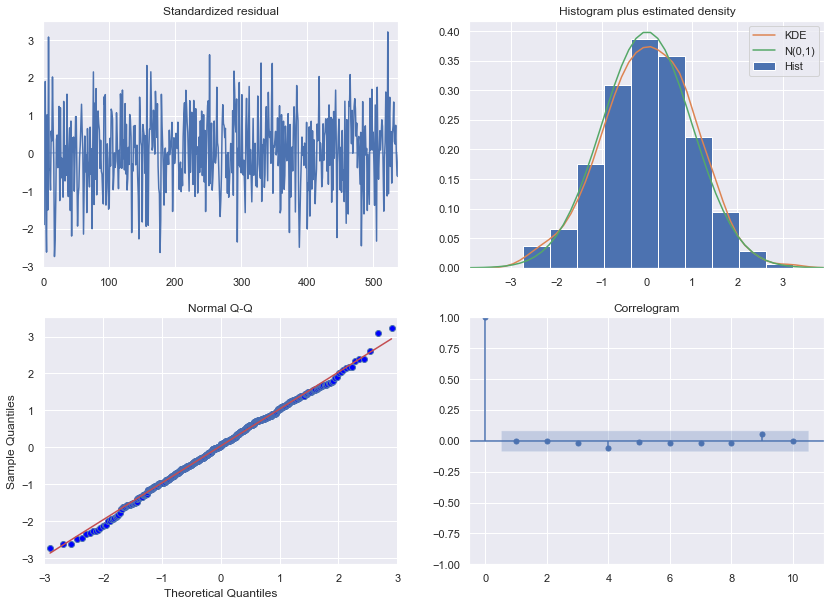

In [57]:
autoarima_model2.plot_diagnostics(figsize=(14,10))
plt.show()

In [81]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,1.457067,0.999063,1.438395,0.999115


### D. Predictions

In [59]:
fh = list(range(1, 1+len(y_test)))
y_pred = autoarima_model.predict(fh=fh )

<AxesSubplot:xlabel='ds'>

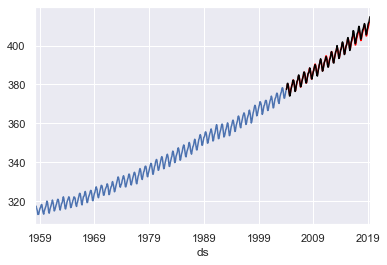

In [60]:
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

In [61]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
smape = MeanAbsolutePercentageError(symmetric=True)
smape(y_test, y_pred)

0.0012333403627227415

In [62]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
mase = MeanAbsoluteScaledError()
mase(y_test, y_pred, y_train=y_train)

0.4560763291757719

In [63]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError
mae = MeanAbsoluteError()
mae(y_test, y_pred)

0.49091226842790703

In [64]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_test, y_pred)

0.4370627905738669

In [65]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
mape = MeanAbsolutePercentageError(symmetric=False)
mape(y_test, y_pred)

0.0012325053335257388

### E. SARIMA and AUTOARIMA

- In terms of orders, we have:

    - SARIMA: (9, 1, 3)x(10, 1, 10, 12)
    - AUTO ARIMA: (4, 0, 0)x(5, 1, 1, 12)	

- We can compare **models performances** to make predictions based on performance metrics. For example, by looking at sMAPE we can notice that AUTO ARIMA has a better performance (lower deviation from true values):

    - SARIMA: 0.005345291642172526
    - AUTO ARIMA: 0.0012333403627227415

- Therefore, between the two models, I will use AUTOARIMA model given its better performance.

## 4. Bonus

#### A. Rolling

In [77]:
class RollingFit:
    def __init__(self, y, train_size=551, model=AutoARIMA() ):
        
        self.y = y
        self.model = model
        
        self.train_y, self.test_y = temporal_train_test_split(y, train_size=5)
        self._test_y = self.test_y
        self.ypred_ = self.train_y
        self.fit()
        
    def fit(self):
        N = len( self.test_y )
        for i in range(0, N):
            
            self.fit_model()
            ypred = self.predict_one()
            self.add_to_predictions( ypred )
            self.move_one_test_to_train()
            self.drop_one_from_test()
    
    def fit_model(self):
        y = self.train_y
        self.model.fit( y )

In [80]:
rolling_fit_model = RollingFit(y_train, model=ARIMA((4,0,0), seasonal_order=(5,1,1,12) ))

LinAlgError: Schur decomposition solver error.

In [ ]:
rolling_fit_model.y.plot(color='red')
plt.show()
rolling_fit_model.ypred_.plot()
plt.show()

#### B. 

#### C.  MAE, MSE, MAPE, sMAPE, MASE

In [ ]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
smape = MeanAbsolutePercentageError(symmetric=True)
smape(y_test, y_pred)

In [ ]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
mase = MeanAbsoluteScaledError()
mase(y_test, y_pred, y_train=y_train)

In [ ]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError
mae = MeanAbsoluteError()
mae(y_test, y_pred)

In [ ]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_test, y_pred)

In [ ]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
mape = MeanAbsolutePercentageError(symmetric=False)
mape(y_test, y_pred)

#### D. Comparing models

- We can compare **models performances** to make predictions based on performance metrics. For example, by looking at sMAPE we can notice that Recursive method has a better performance (lower deviation from true values):

    - Recursive method: 0.005345291642172526
    - AUTO ARIMA: 0.0012333403627227415

- Therefore, between the two models, I will use Recursive method model given its better performance.
